# Olfaction basics

**Author:** Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will implement a simple controller for odor-guided taxis.

The olfactory system in _Drosophila_ consists of specialized olfactory sensory neurons (OSNs) located in the antennae and maxillary palps. These detect specific odorant molecules and convey this information to the brain’s antennal lobe, where their signals are further processed. This is shown in the figure below (left, source: [Martin et al, 2013](https://doi.org/10.1002/ar.22747)) We emulated peripheral olfaction by attaching virtual odor sensors to the antennae and maxillary palps of our biomechanical model, as shown in the figure (right). The user has the option of configuring additional sensors at more precise locations on these olfactory organs. These virtual sensors can detect odor intensities across a multi-dimensional space that can be thought of as representing, for example, the concentrations of monomolecular chemicals sensed by OSNs in the antennae, or the intensities of composite odors co-activating numerous projection neurons in the antennal lobe.

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/olfaction_basics/olfaction.png?raw=true" alt="rule_based" width="700"/>

## Odor arena

To demonstrate odor sensing, let's create an environment with one attractive odor source and two aversive odor sources. The dimension of this odor space is 2 (attractive, aversive) despite the number of odor sources being 3. The odor sources share a peak intensity of 1. We will color the attractive odor source orange and the aversive odor sources blue.

In [1]:
import numpy as np

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0], [0, 1], [0, 1]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

Let's create the arena using these parameters. The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/arena/sensory_environment.py).

In [2]:
from flygym.arena import OdorArena

arena = OdorArena(
    odor_source=odor_source,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

Let’s place our fly in the arena. As before, we will run a few iterations to allow it to stand on the ground in a stable manner.

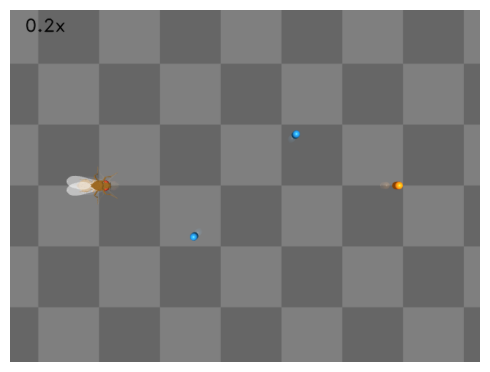

In [3]:
import matplotlib.pyplot as plt
from flygym import Fly, Camera
from flygym.examples.locomotion import HybridTurningController
from pathlib import Path

outputs_dir = Path("./outputs/olfaction_basics")
outputs_dir.mkdir(parents=True, exist_ok=True)

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
)

cam_params = {
    "mode":"fixed",
    "pos": (odor_source[:, 0].max() / 2, 0, 35),
    "euler":(0, 0, 0), "fovy":45
    }
    
cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="birdeye_cam",
    timestamp_text = False,
    camera_parameters=cam_params
)

sim = HybridTurningController(
    fly=fly,
    cameras=[cam],
    arena=arena,
    timestep=1e-4,
)
for i in range(500):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")
fig.savefig(outputs_dir / "olfaction_env.png")

## Controller for odor taxis

Let's design a simple hand-tuned controller for odor-guided taxis. We start by calculating the left-right asymmetry of the odor intensity $I$ for each odor $o$:

$$
\Delta I_o = \frac{I_\text{left,o} - I_\text{right,o}}{(I_\text{left,o} + I_\text{right,o}) / 2}
$$

Then, we multiply $\Delta I_o$ by a gain $\gamma_o$ for each odor dimension and take the sum $s$. Attractive and aversive odors will have different signs in their gains.

$$
s = \sum_{o} \gamma_o \Delta I_o
$$

We transform $s$ nonlinearly to avoid overly drastic turns when the asymmetry is subtle and to crop it within the range [0, 1). This gives us a turning bias $b$:

$$
b = \tanh(s^2)
$$

Finally, we modulate the descending signal $\delta$ based on $b$ and the sign of $s$:

$$
\delta_\text{left} = 
    \begin{cases}
    \delta_\text{max} & \text{if } s>0\\
    \delta_\text{max} - b(\delta_\text{max} - \delta_\text{min})  & \text{otherwise}
    \end{cases}
    \qquad
    \delta_\text{right} = 
    \begin{cases}
    \delta_\text{max} - b(\delta_\text{max} - \delta_\text{min}) & \text{if } s>0\\
    \delta_\text{max}  & \text{otherwise}
    \end{cases}
$$

where, $\delta_\text{min}$, $\delta_\text{max}$ define the range of the descending signal. Here, we will use the following parameters:

- $\gamma_\text{attractive} = -500$ (negative ipsilateral gain leads to positive taxis)
- $\gamma_\text{aversive} = 80$ (positive ipsilateral gain leads to negative taxis)
- $\delta_\text{min} = 0.2$
- $\delta_\text{max} = 1$

As before, we will recalculate the steering signal every 0.05 seconds. Let's implement this in Python:

In [4]:
from tqdm import trange

attractive_gain = -500
aversive_gain = 80
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset()
for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    aversive_bias = (
        aversive_gain
        * (aversive_intensities[0] - aversive_intensities[1])
        / aversive_intensities.mean()
    )
    effective_bias_smooth = aversive_bias + attractive_bias
    effective_bias_norm = np.tanh(effective_bias_smooth**2) * np.sign(effective_bias_smooth)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias_smooth)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

    # Stop when the fly is within 2mm of the attractive odor source
    if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
        break

 51%|█████     | 51/100 [00:38<00:37,  1.32it/s]


We can visualize the fly trajectory:

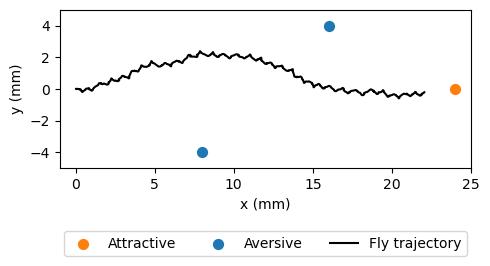

In [5]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(outputs_dir / "odor_taxis_trajectory.png")

We can also generate the video:

In [6]:
from IPython.display import Video

cam.save_video(outputs_dir / "odor_taxis.mp4")
Video(outputs_dir / "odor_taxis.mp4")

# Exercise 3: Odor from behind
In this exercise, let's simulate a scenario in which an attractive odor source is placed directly behind the fly. How do you expect the fly to behave in this case?

In [ ]:
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim.timestep)

#################################################################
# TODO: Create an odor arena with a single attractive odor source
# placed 3mm behind the fly
gains = np.array([-500, 80])
odor_source = np.array([[-3, 0, 1.5]])

arena = OdorArena(
    odor_source=odor_source,
    peak_odor_intensity=[[1, 0]],
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)
#################################################################

fly = Fly(
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
)

cam_params = {
    "mode":"fixed",
    "pos": (odor_source[:, 0].max() / 2, 0, 35),
    "euler":(0, 0, 0), "fovy":45
    }
    
cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="birdeye_cam",
    timestamp_text = False,
    camera_parameters=cam_params
)

sim = HybridTurningController(
    fly=fly,
    cameras=[cam],
    arena=arena,
    timestep=1e-4,
)

attractive_gain = -500
aversive_gain = 80
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim.timestep)

obs, _ = sim.reset()

for i in trange(num_decision_steps):
    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    attractive_bias = (
        attractive_gain
        * (attractive_intensities[0] - attractive_intensities[1])
        / attractive_intensities.mean()
    )
    effective_bias_smooth = attractive_bias
    effective_bias_norm = np.tanh(effective_bias_smooth**2) * np.sign(effective_bias_smooth)
    assert np.sign(effective_bias_norm) == np.sign(effective_bias_smooth)

    control_signal = np.ones((2,))
    side_to_modulate = int(effective_bias_norm > 0)
    modulation_amount = np.abs(effective_bias_norm) * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        sim.render()

    # Stop when the fly is within 2 mm of the attractive odor source
    if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
        break

cam.save_video(outputs_dir / "behind.mp4")
Video(outputs_dir / "behind.mp4")

 37%|███▋      | 37/100 [00:28<00:48,  1.31it/s]


# Exercise 4: Attraction vs aversion
Let's consider the case a fly is attracted to an object placed at (4, 2, 1.5):

 35%|███▌      | 7/20 [00:06<00:11,  1.14it/s]


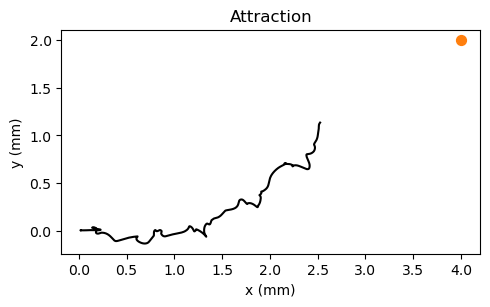

In [8]:
def run_simulation(
    odor_source,
    marker_colors,
    odor_gains,
    peak_odor_intensity,
    timestep=1e-4,
    run_time=1,
    decision_interval=0.05,
    fly_class=Fly,
):
    num_decision_steps = int(run_time / decision_interval)
    physics_steps_per_decision_step = int(decision_interval / timestep)
    assert all(len(odor_gains) == len(i) for i in peak_odor_intensity)
    attractive_gain, aversive_gain = odor_gains

    arena = OdorArena(
        odor_source=odor_source,
        peak_odor_intensity=peak_odor_intensity,
        diffuse_func=lambda x: x**-2,
        marker_colors=marker_colors,
        marker_size=0.3,
    )

    fly = fly_class(
        spawn_pos=(0, 0, 0.2),
        contact_sensor_placements=contact_sensor_placements,
        enable_olfaction=True,
        enable_adhesion=True,
        draw_adhesion=False,
    )

    cam_params = {
        "mode":"fixed",
        "pos": (odor_source[:, 0].max() / 2, 0, 35),
        "euler":(0, 0, 0), "fovy":45
        }
        
    cam = Camera(
        attachment_point=arena.root_element.worldbody,
        camera_name="birdeye_cam",
        timestamp_text = False,
        camera_parameters=cam_params
    )

    sim = HybridTurningController(
        fly=fly,
        cameras=[cam],
        arena=arena,
        timestep=1e-4,
    )

    obs_hist = []
    obs, _ = sim.reset()
    for i in trange(num_decision_steps):
        attractive_intensities = np.average(
            obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
        )
        aversive_intensities = np.average(
            obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
        )
        attractive_bias = (
            attractive_gain
            * (attractive_intensities[0] - attractive_intensities[1])
            / np.maximum(attractive_intensities.mean(), 1e-6)
        )
        aversive_bias = (
            aversive_gain
            * (aversive_intensities[0] - aversive_intensities[1])
            / np.maximum(aversive_intensities.mean(), 1e-6)
        )
        effective_bias = aversive_bias + attractive_bias
        effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
        assert np.sign(effective_bias_norm) == np.sign(effective_bias)

        control_signal = np.ones((2,))
        side_to_modulate = int(effective_bias_norm > 0)
        modulation_amount = np.abs(effective_bias_norm) * 0.8
        control_signal[side_to_modulate] -= modulation_amount

        for _ in range(physics_steps_per_decision_step):
            obs, _, _, _, _ = sim.step(control_signal)
            sim.render()
            obs_hist.append(obs)

        # Stop when the fly is within 2mm of the attractive odor source
        if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
            break

    return obs_hist, sim

def plot_trajectory(obs_hist, odor_source, marker_colors):
    fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

    for (x, y), color in zip(odor_source[:, :2], marker_colors):
        ax.scatter(x, y, marker="o", color=color, s=50)

    ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
    ax.set_aspect("equal")
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")


odor_source = np.array([[4, 2, 1.5]])
marker_colors = np.array([[255, 127, 14, 255]]) / 255

obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([-250, 250]),
)
sim.cameras[0].save_video(outputs_dir / "attraction.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
plt.title("Attraction")
Video(outputs_dir / "attraction.mp4")

100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


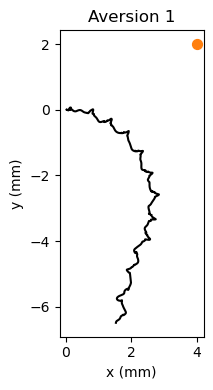

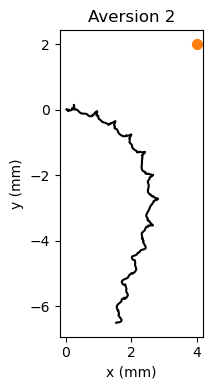

In [9]:
######################################################################
# TODO: Modify one parameter to make the fly avoid the odor source
obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[0, 1]]), # [1, 0] -> [0, 1]
    odor_gains=np.array([-250, 250]),
)
######################################################################
sim.cameras[0].save_video(outputs_dir / "aversion1.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
plt.title("Aversion 1")

######################################################################
# TODO: Modify another parameter to make the fly avoid the odor source
obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([250, -250]),   # [-250, 250] -> [250, -250]
)
######################################################################
sim.cameras[0].save_video(outputs_dir / "aversion2.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
plt.title("Aversion 2")
Video(outputs_dir / "aversion2.mp4")

# Exercise 5: Noisy sensors
Let's see what happens when the measurements of odor intensity are noisy:

In [10]:
class NoisyFly(Fly):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rng = np.random.RandomState(0)

    def get_observation(self, *args, **kwargs):
        obs = super().get_observation(*args, **kwargs)
        # Inject multiplicative noise into the odor intensity
        var = 5
        obs["odor_intensity"] *= self.rng.gamma(1 / var, var, obs["odor_intensity"].shape)
        return obs

100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


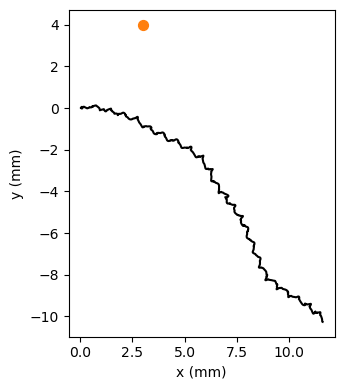

In [11]:
odor_source = np.array([[3, 4, 1.5]])
marker_colors = np.array([[255, 127, 14, 255]]) / 255
peak_odor_intensity = np.array([[1, 0]])
obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([-250, 0]),
    run_time=2,
    fly_class=NoisyFly,
)
sim.cameras[0].save_video(outputs_dir / "noisy.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
Video(outputs_dir / "noisy.mp4")

Let's implement a new control algorithm to make the fly turn toward the odor source in the presence of noise:

In [12]:
def run_simulation2(
    odor_source,
    marker_colors,
    odor_gains,
    peak_odor_intensity,
    timestep=1e-4,
    run_time=1,
    fly_class=Fly,
):
    assert all(len(odor_gains) == len(i) for i in peak_odor_intensity)
    attractive_gain, aversive_gain = odor_gains

    arena = OdorArena(
        odor_source=odor_source,
        peak_odor_intensity=peak_odor_intensity,
        diffuse_func=lambda x: x**-2,
        marker_colors=marker_colors,
        marker_size=0.3,
    )

    fly = fly_class(
        spawn_pos=(0, 0, 0.2),
        contact_sensor_placements=contact_sensor_placements,
        enable_olfaction=True,
        enable_adhesion=True,
        draw_adhesion=False,
    )

    cam_params = {
        "mode":"fixed",
        "pos": (odor_source[:, 0].max() / 2, 0, 35),
        "euler":(0, 0, 0), "fovy":45
        }
        
    cam = Camera(
        attachment_point=arena.root_element.worldbody,
        camera_name="birdeye_cam",
        timestamp_text = False,
        camera_parameters=cam_params
    )

    sim = HybridTurningController(
        fly=fly,
        cameras=[cam],
        arena=arena,
        timestep=1e-4,
    )

    effective_bias_smooth = 0

    obs_hist = []
    obs, _ = sim.reset()
    for i in trange(int(run_time / timestep)):
        attractive_intensities = np.average(
            obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
        )
        aversive_intensities = np.average(
            obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
        )
        attractive_bias = (
            attractive_gain
            * (attractive_intensities[0] - attractive_intensities[1])
            / np.maximum(attractive_intensities.mean(), 1e-6)
        )
        aversive_bias = (
            aversive_gain
            * (aversive_intensities[0] - aversive_intensities[1])
            / np.maximum(aversive_intensities.mean(), 1e-6)
        )
        effective_bias = aversive_bias + attractive_bias
        
        #################################################################
        # TODO: Calculate the exponential moving average of s
        # Refer to https://en.wikipedia.org/wiki/Exponential_smoothing
        alpha = 0.001
        effective_bias_smooth = (1 - alpha) * effective_bias_smooth + alpha * effective_bias
        ################################################################

        effective_bias_norm = np.tanh(effective_bias_smooth**2) * np.sign(effective_bias_smooth)
        assert np.sign(effective_bias_norm) == np.sign(effective_bias_smooth)

        control_signal = np.ones((2,))
        side_to_modulate = int(effective_bias_norm > 0)
        modulation_amount = np.abs(effective_bias_norm) * 0.8
        control_signal[side_to_modulate] -= modulation_amount

        obs, _, _, _, _ = sim.step(control_signal)
        sim.render()
        obs_hist.append(obs)

        # Stop when the fly is within 2mm of the attractive odor source
        if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
            break

    return obs_hist, sim

 29%|██▉       | 5853/20000 [00:09<00:22, 637.89it/s]


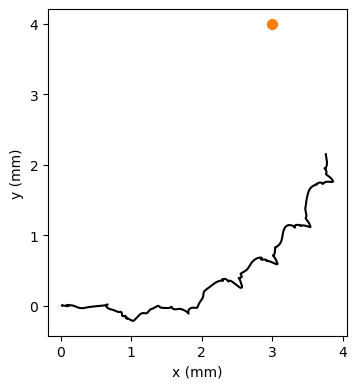

In [13]:
odor_source = np.array([[3, 4, 1.5]])
marker_colors = np.array([[255, 127, 14, 255]]) / 255
peak_odor_intensity = np.array([[1, 0]])
obs_hist, sim = run_simulation2(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([-250, 0]),
    run_time=2,
    fly_class=NoisyFly,
)
sim.cameras[0].save_video(outputs_dir / "smoothed.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
Video(outputs_dir / "smoothed.mp4")